# Simple plenoptic example

Maybe for a quick start? Doesn't show anything complicated, but shows the basics.

In [1]:
import plenoptic as po
import torch
import pyrtools as pt

%matplotlib inline

We need a reference image, so load one in.

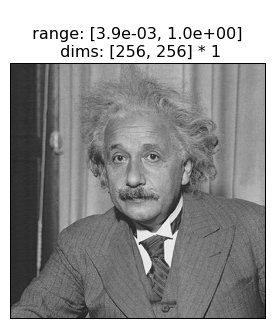

In [2]:
im = po.load_images('../data/einstein.pgm')
fig = po.imshow(im)

Models can be really simple, as this demonstrates. It needs to inherit `torch.nn.Module` and just needs two methods: `__init__` (so it's an object) and `forward` (so it can take an image.

Now we initialize the model and call its forward method

In [3]:
model = po.simul.Linear_Nonlinear()
rep = model(im)

We see that `im` is a 4d tensor (batch by channel by height by width) and that our model returns a 3d representation (batch by channel by something). Models need to take in 4d tensors and return 3d or 4d.

In [4]:
print(im.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 250, 250])


And we see it's just a bunch of floats

In [5]:
rep[..., :5, :5]

tensor([[[[0.1802, 0.1844, 0.1834, 0.1831, 0.1839],
          [0.1835, 0.1886, 0.1886, 0.1890, 0.1899],
          [0.1807, 0.1868, 0.1881, 0.1895, 0.1907],
          [0.1786, 0.1853, 0.1875, 0.1897, 0.1913],
          [0.1781, 0.1846, 0.1869, 0.1894, 0.1915]],

         [[0.0148, 0.0094, 0.0088, 0.0079, 0.0075],
          [0.0095, 0.0042, 0.0043, 0.0041, 0.0036],
          [0.0079, 0.0035, 0.0047, 0.0051, 0.0046],
          [0.0069, 0.0032, 0.0047, 0.0051, 0.0047],
          [0.0069, 0.0027, 0.0042, 0.0050, 0.0047]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]], grad_fn=<SliceBackward>)

Now initialize the metamer object, which requires the model and the reference image

In [6]:
metamer = po.synth.Metamer(im, model)

And call `synthesize`. This has a handful of optional arguments. You'll probably need to play around with some of the optimization-related ones, like `max_iter`, `learning_rate`, and `optimizer` (see the `Metamer` dosctring or notebook for more info), and you probably want to set `store_progress` to `True` (to store every iteration) or some `int` (to store every `int` iterations) so you can examine synthesis progress.

In [7]:
matched_im, matched_rep = metamer.synthesize(store_progress=True, learning_rate=.1, optimizer='Adam')

100%|██████████| 100/100 [00:04<00:00, 23.39it/s, gradient_norm=7.3268e-01, learning_rate=0.05, loss=7.7895e-01, pixel_change=1.4814e-02]


We can then look at the reference and metamer images:

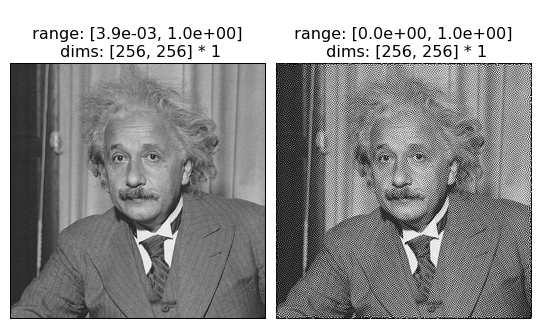

In [8]:
fig = po.imshow([im, matched_im]);

And view a movie of our progress so far

In [9]:
po.convert_anim_to_html(metamer.animate(plot_representation_error=False, figsize=(12, 5)))

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/synthesis.py:2056: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"


In a similar fashion, we can call `MADCompetition`. It requires two models, so we compare it against the `Identity` model, which just returns a copy of the image, and thus is roughly equivalent to using mean-squared error as a metric (we actually use the L2-norm, but you can change that if you'd like)

In [10]:
mad = po.synth.MADCompetition(im, model, po.simul.models.naive.Identity())

And again, call `synthesize`. `MADCompetition` has similar attributes, but one big difference is that its stimuli come in sets of 4, so you have to set the synthesis target (see the `MADCompetition` docstring or notebook for more info).

In [11]:
matched_im, matched_rep_1, matched_rep_2 = mad.synthesize('model_1_min', store_progress=True, optimizer='Adam',)

100%|██████████| 100/100 [00:10<00:00,  9.79it/s, gradient_norm=1.8381e-02, learning_rate=0.00781, loss=6.6013e-02, pixel_change=2.2852e-03, stable_loss=9.9394e-01]


And similarly, we can view an animation to see the progress. Notice there are two losses here, one for each model.

In [12]:
po.convert_anim_to_html(mad.animate(plot_representation_error=False, figsize=(12, 5)))

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/synthesis.py:2056: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"
